# Implementation
The Poisson problem has so far featured general domain $\Omega$ and general functions $u_D$ for the boundary conditions and $f$ for the right hand side.
Therefore, we need to make specific choices of $\Omega, u_D$ and $f$. A wise choice is to construct a problem  with a known analytical solution, so that we can check that the computed solution is correct. The primary candidates are lower-order polynomials. The continuous Galerkin finite element spaces of degree $r$ will exactly reproduce polynomials of degree $r$. 
<!-- Particularly, piecewise linear continuous Galerkin finite elements are able to exactly reproduce a quadratic polynomial on 
a uniformly partitioned mesh. -->
 We use this fact to construct a quadratic function in $2D$. In particular we choose
\begin{align}
 u_e(x,y)=1+x^2+2y^2
 \end{align}

Inserting $u_e$ in the original boundary problem, we find that  
\begin{align}
    f(x,y)= -6,\qquad u_d(x,y)=u_e(x,y)=1+x^2+2y^2,
\end{align}
regardless of the shape of the domain as long as we prescribe 
$u_e$ on the boundary.

For simplicity, we choose the domain to be a unit square $\Omega=[0,1]\times [0,1]$

This simple but very powerful method for constructing test problems is called _the method of manufactured solutions_. 
First pick a simple expression for the exact solution, plug into
the equation to obtain the right-hand side (source term $f$). Then solve the equation with this right hand side, and using the exact solution as boundary condition. Finally, we create a program that tries to reproduce the exact solution.

Note that in many cases, it can be hard to determine if the program works if it produces an error of size $10^{-5}$ on a
$20 \times 20$ grid. However, since we are using Sobolev spaces,
we usually known about the numerical errors _asymptotic properties_. For instance that it is proportional to $h^2$ if $h$ is the size of a cell in the mesh. We can then compare the error on meshes with different $h$-values to see if the asymptotic behavior is correct. This technique will be explained in detail in a later chapter *FIXME: add correct reference*.

However, in cases where we have a solution we know that should have no approximation error, we know that the solution should
be produces to machine precision by the program.

The first eight lines of the program is importing the different modules required for solving the problem.

In [24]:
import dolfinx
import dolfinx.cpp
import dolfinx.mesh
import dolfinx.plotting
import matplotlib.pyplot
import numpy
import ufl
from mpi4py import MPI
from petsc4py import PETSc

A major difference between a traditional FEniCS code and a FEniCS-X code, is that one is not advised to use the wildcard import. Instead of wrapping [MPI](https://mpi4py.readthedocs.io/en/stable/) and [PETSc](https://pypi.org/project/petsc4py/) modules inside dolfin-X, we would like to directly use the modules, as they are  well documented and makes dolfin-X easier to understand.

## Generating  simple meshes
The next step is to define the discrete domain, _the mesh_


In [25]:
mesh = dolfinx.UnitSquareMesh(MPI.COMM_WORLD, 8, 8, dolfinx.cpp.mesh.CellType.triangle)

which defines a uniform finite element mesh over the unit square $\[0,1]\times\[0, 1]$. The mesh consists of _cells_, which in 2D can be either triangles of quadrilaterals. Note that in addition to give how many elements we would like to have in each direction. We start by dividing the domain into $8\times 8$ quadrilaterals, which are subdivided into two triangles if
we will use triangular cells.
Note that we also supply the _MPI-communicator_. 
This is to specify how we would like the program to behave in parallel. If we supply `MPI.COMM_WORLD` we create a single mesh,
which data is distributed over the number of processors we 
would like to use. We can for instance run the program in 
parallel on two processors by using `mpirun`, as: 
``` bash
 mpirun -n 2 python3 t1.py
```
However, if we would like to create a separate mesh on each processor, we can use `MPI.COMM_SELF`. This is for instance 
useful if we run a small problem, and would like to run it with
multiple parameters.

## Defining the finite element function space
 Once the mesh has been created, we can create the finite element function space $V$:


In [11]:
 V = dolfinx.FunctionSpace(mesh, ("CG", 1))

The second argument is the tuple containing the type of finite element, and the element degree. The type of element here is "CG", which implies the standard Lagrange family of elements. 
Dolfin-X supports a large variety on elements on simplices 
(triangles and tetrahedrons) and non-simplices (quadrilaterals
and hexahedrons). For an overview, see:
*FIXME: Add link to all the elements we support*

The element degree in the code is 1. This means that we are choosing the standard $P_1$ linear Lagrange element, which has degrees of freedom at the vertices. The computed solution will be continuous across elements and linearly varying in $x$ and $y$ inside each element. Higher degree polynomial approximations is obtained by increasing the degree argument. 

## Defining the boundary conditions

The next step is to specify the boundary condition $u=u_D$ on $\partial\Omega_D$, which is done by


In [12]:
uD = dolfinx.Function(V)
uD.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2)
uD.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
fdim = mesh.topology.dim - 1
boundary_facets = dolfinx.mesh.locate_entities_boundary(
    mesh, fdim, lambda x: numpy.full(x.shape[1], True, dtype=numpy.bool))
bc = dolfinx.DirichletBC(uD, dolfinx.fem.locate_dofs_topological(V, fdim, boundary_facets))

As we observe here, this is done  over several steps. The first step is to define the function that will contain the boundary information, `uD`. The next step is to interpolate the spatially
varying function into the function space. We use the [lambda-function](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) in Python to compactly define the 
spatially varying function. As we in our example distribute 
the the mesh the number of processors used, we need to 
update data on boundaries between processors. We do 
this by updating the underlying PETSc function.
We now have the boundary data (and in this case the solution of 
the finite element problem) represented in the discrete function space. Next we would like to apply the boundary values to all degrees of freedom that is on the boundary of the discrete domain. We start by identifying the facets (line-segments)
representing the outer boundary, using `locate_entities_boundary`. As one in most cases, as shown in later tutorials, only want to mark subsets of the outer boundary, we need to supply a function using a geometrical criteria for which facets should be marked. In this case, as we want to mark the whole boundary, we create a lambda-function that returns `True` for all facets on the boundary. 
Now that we have located the boundary facets, we locate the
dofs contained on these facets, using `locate_dofs_topological` and create the Dirichlet boundary condition.


## Defining the trial and test function

In mathematics, we distinguish between trial and test spaces $V$ and $\hat{V}$. The only difference in the present problem is the boundary conditions. In FEniCS-X, we do not specify boundary conditions as part of the function space, so it is sufficient to use a common space for the trial and test function:

In [13]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

## Defining the source term
As the source term is constant over the domain, we can efficiently represent is as constant:

In [14]:
f = dolfinx.Constant(mesh, -6)

This will speed of compilation of high performance 
C code for creating the linear system, as opposed to
`f = -6`.
## Defining the variational problem
We now have all the ingredients to define the variational problem

In [15]:
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

Note that there is a very close correspondence between the Python syntax and the mathematical syntax
$\nabla u \cdot \nabla v \mathrm{d} x$ and $fv\mathrm{d} x$. 
This is the key strength of FEniCS-X: the formulas in the variational formulation translate directly to very similar Python code, a feature that makes it easy to specify and solve complicated PDE problems. The language used to express weak forms is the Unified Form Language (UFL){cite}`ufl2014`.

## Expressing inner products
The inner product $\int_\Omega \nabla u \cdot \nabla v \mathrm{d} x$ can be expressed in various ways in UFL. We have used the notation `ufl.dot(ufl.grad(u), ufl.grad(v))*uf.dx`. The dot product in UFL computes the sum (contraction) over the last index of the first factor and first index of the second factor. In this case, both factors are tensors of rank one (vectors) and so the sum is just over the single index of both $\nabla u$ and $\nabla v$. To compute an inner product of matrices (with two indices), one must instead of `ufl.dot` use the function `ufl.inner`. For vectors, `ufl.dot` and `ufl.inner` are equivalent.

## Forming and solving the linear system

Having defined the finite element variational problem and boundary condition, we can use dolfin-X to compute the solution:

In [16]:
uh = dolfinx.Function(V)
dolfinx.solve(a == L, uh, bc, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

Here we have defined our approximate function `uh`, which will store the solution. The `solve`-command takes in the variational equality, the discrete function, the boundary condition and options to the backend linear algebra solver PETSc. In this case, we would like to solve the problem with a direct solver. See the [PETSc-documentation](https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/PC/PCLU.html) of the method for more information.

Then, as after interpolation, we update shared indices not owned by the processor.

## Plotting the solution using the built-in plotting
Once the solution has been computed, we visualize it with the plot command

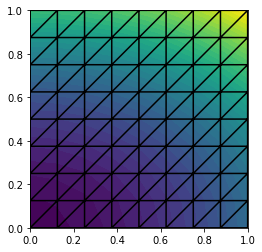

In [17]:
dolfinx.plotting.plot(uh)
dolfinx.plotting.plot(mesh, color="k")
matplotlib.pyplot.savefig("uh.png")

We start by plotting the solution of the function, and overlays it with the mesh. Finally, we save the plot with matplotlib. 
One can also visualize this plot in an non-interactive mode, using `matplotlib.pyplot.show()`.

For more advanced post-processing, it is suggested to save the solution to file using either `dolfinx.io.VTKFile` or `dolfinx.io.XDMFFile` and using [Paraview](https://www.paraview.org/). This ifs especially suggested for 3D visualization.

In [18]:
import dolfinx.io
outfile = dolfinx.io.VTKFile("output.pvd")
outfile.write(uh)
xdmffile = dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output.xdmf", "w")
xdmffile.write_mesh(mesh)
xdmffile.write_function(uh)
xdmffile.close()

## Computing the error

Finally, we compute the error to check the accuracy of the solution. We do this by comparing the finite element solution `u` with the exact solution. We do this by interpolating the exact solution into the the $P_2$-function space.

In [19]:
V2 = dolfinx.FunctionSpace(mesh, ("CG", 2))
uex = dolfinx.Function(V2)
uex.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2)
uex.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

We compute the error in two different ways. First, we compute the $L^2$-norm of the error, defined by $E=\sqrt{\int_\Omega (u_D-u_h)^2\mathrm{d} x}$. We use UFL to express the $L^2$-error:

In [21]:
error_L2 = numpy.sqrt(dolfinx.fem.assemble_scalar(ufl.inner(uh - uex, uh - uex) * ufl.dx))

We also compute the maximum error at any degree of freedom.
As the finite element function $u$ can be expressed as a linear combination of basis functions $\phi_j$, spanning the space $V$:

$ u = \sum_{j=1}^N U_j\phi_j.$
By writing `solve(...)`
we compute all the coefficients $U_1,\dots, U_N$. These values are known as the _degrees of freedom_ (dofs). We can access the degrees of freedom by accessing the underlying vector in `uh`.
However, as a second order function space has more dofs than a linear function space, we cannot compare these arrays directly.
Therefore we compute the values of both `uex` and `uD` at the mesh nodes (for a linear mesh this is the vertices).

In [23]:
u_vertex_values = uh.compute_point_values()
u_ex_vertex_values = uex.compute_point_values()
error_max = numpy.max(numpy.abs(u_vertex_values - u_ex_vertex_values))
print("Error_L2 = {0:.2e}".format(error_L2))
print("Error_max = {0:.2e}".format(error_max))

Error_L2 = 8.24e-03
Error_max = 2.22e-15


## References
```{bibliography} references_impelementation.bib
```
